### Attempting to compute Fisher matrix

#### First: calculate derivative
### $\frac{\partial\chi}{\partial\Omega_m} \simeq \frac{\chi(\Omega_m^+)-\chi(\Omega_m^-)}{2\Delta\Omega_m}$

In [18]:

def get_filenames(rmin,rmax,rbin,njk,ns,cosm,space):
    filename = f'vpfdata_{rmin}-{rmax}-{rbin}-{njk}-{ns}-{cosm}-{space}*.dat'
    return filename
def compute_mean_cov(summaries):
    mean = np.mean(summaries, axis=0)
    covariance = np.cov(summaries.T)
    inverse_covariance = np.linalg.solve(
        covariance, np.eye(len(covariance), len(covariance))
    )
    corrm = np.corrcoef(summaries.T)
    return mean, covariance, inverse_covariance, corrm

import glob
import numpy as np
from astropy.io import ascii

# Parameters
# cosm = 'Om_m'
ns = int(10000)
rbin = int(13)
rmin, rmax = 3., int(25)
njk = int(10)
space = 'zspace'
#filedir = '/home/federico/mnts/clemente/Proyectos/VPF_Quijote/data/output/'
filedir = '../data/output/'

for cosm in ['Om_m','Om_p','fiducial']:

    filenames = get_filenames(rmin,rmax,rbin,njk,ns,cosm,space)

    filelist = glob.glob(filedir+filenames)
    nsim = len(filelist)
    print(cosm, nsim)

    chis = []
    nxis = []
    chi_stds = []

    #if cosm != 'fiducial': filelist=filelist[:100]
    # Read all files
    for file in filelist:
        #print(file)
        data = ascii.read(file)
        chis.append( data['chi'] )
        nxis.append( data['N_mean']*data['xi'] )
        chi_stds.append( data['chi_std'] )


    if cosm=='Om_m':
        mean_Om_m, covariance_Om_m, inverse_covariance_Om_m, corrm_Om_m = compute_mean_cov(np.array(chis))
    if cosm=='Om_p':
        mean_Om_p, covariance_Om_p, inverse_covariance_Om_p, corrm_Om_p = compute_mean_cov(np.array(chis))
    if cosm=='fiducial':
        mean_fid, covariance_fid, inverse_covariance_fid, corrm_fid = compute_mean_cov(np.array(chis))

mu_Om = 0.3175

dChi_dOm = (mean_Om_p-mean_Om_m)/(2*0.01)
print(dChi_dOm)

Om_m 499
Om_p 499


KeyboardInterrupt: 

#### Fisher forecast for $\Omega_m$
#### $F_{\Omega_m}=\frac{\partial\chi}{d\Omega_m}C^{-1}\frac{\partial\chi^T}{d\Omega_m}$
#### $\sigma_{\Omega_m}^2=(F^{-1})_{\Omega_m}$

In [6]:
covfactor = (2994-1)/(2994-13+6-1)
f_Om = dChi_dOm @ np.linalg.inv(covfactor*covariance_fid) @ dChi_dOm.T
#sigma_Om = np.sqrt(1/f_Om)

print(f_Om)

28652.03867846509


In [7]:
# def gaussian(x,mu,sigma,norm=True):
#     g = np.exp(-(x - mu)**2 / (2 * sigma**2))
#     if norm==True:
#         g /= g.max()
#     return g

# import matplotlib.pyplot as plt
# import numpy as np

# lw = 3
# mu_Om = 0.3175
# x = np.linspace(mu_Om - 6*sigma_Om, mu_Om + 6*sigma_Om, 100)
# plt.plot(x, gaussian(x, mu_Om, 0.04221), label='2PCF', lw=lw)
# plt.plot(x, gaussian(x, mu_Om, sigma_Om), label='VPF', lw=lw)
# plt.plot(x, gaussian(x, mu_Om, 0.01128), label='DS', lw=lw)
# plt.xlabel(r'$\Omega_m$')
# plt.legend()
# plt.show()

### Same with $h$

In [8]:

def get_filenames(rmin,rmax,rbin,njk,ns,cosm,space):
    filename = f'vpfdata_{rmin}-{rmax}-{rbin}-{njk}-{ns}-{cosm}-{space}*.dat'
    return filename
def compute_mean_cov(summaries):
    mean = np.mean(summaries, axis=0)
    covariance = np.cov(summaries.T)
    inverse_covariance = np.linalg.solve(
        covariance, np.eye(len(covariance), len(covariance))
    )
    corrm = np.corrcoef(summaries.T)
    return mean, covariance, inverse_covariance, corrm

import glob
import numpy as np
from astropy.io import ascii

# Parameters
ns = int(10000)
rbin = int(13)
rmin, rmax = 3., int(25)
njk = int(10)
space = 'zspace'
#filedir = '/home/federico/mnts/clemente/Proyectos/VPF_Quijote/data/output/'
filedir = '../data/output/'

for cosm in ['h_m','h_p','fiducial']:

    filenames = get_filenames(rmin,rmax,rbin,njk,ns,cosm,space)

    filelist = glob.glob(filedir+filenames)
    nsim = len(filelist)
    print(cosm, nsim)

    chis = []
    nxis = []
    chi_stds = []

    #if cosm != 'fiducial': filelist=filelist[:100]
    # Read all files
    for file in filelist:
        #print(file)
        data = ascii.read(file)
        chis.append( data['chi'] )
        nxis.append( data['N_mean']*data['xi'] )
        chi_stds.append( data['chi_std'] )


    if cosm=='h_m':
        mean_h_m, covariance_h_m, inverse_covariance_h_m, corrm_h_m = compute_mean_cov(np.array(chis))
    if cosm=='h_p':
        mean_h_p, covariance_h_p, inverse_covariance_h_p, corrm_h_p = compute_mean_cov(np.array(chis))
    if cosm=='fiducial':
        mean_fid, covariance_fid, inverse_covariance_fid, corrm_fid = compute_mean_cov(np.array(chis))

h_fid = 0.6711
h_m = 0.6511
h_p = 0.6911
delta_h = h_p-h_fid
#print(delta_h)
dChi_dh = (mean_h_p-mean_h_m)/(2*delta_h)
#print(dChi_dh)

##########################################################################
# Fisher factor
covfactor = (2994-1)/(2994-13+6-1)
f_h = dChi_dh @ np.linalg.inv(covfactor*covariance_fid) @ dChi_dh.T
#sigma_h = np.sqrt(1/f_h)

print('sigma_h:',f_h)

##########################################################################
# Plot
# def gaussian(x,mu,sigma,norm=True):
#     g = np.exp(-(x - mu)**2 / (2 * sigma**2))
#     if norm==True:
#         g /= g.max()
#     return g

# import matplotlib.pyplot as plt
# import numpy as np

# lw = 3
# x = np.linspace(h_fid - 6*sigma_h, h_fid + 6*sigma_h, 100)
# plt.plot(x, gaussian(x, h_fid, 0.20976), label='2PCF', lw=lw)
# plt.plot(x, gaussian(x, h_fid, sigma_h), label='VPF', lw=lw)
# plt.plot(x, gaussian(x, h_fid, 0.0656), label='DS', lw=lw)
# plt.xlabel(r'$h$')
# plt.legend()
# plt.show()

h_m 499
h_p 499
fiducial 2994
sigma_h: 3227.5118341857665


### Same for $n_s$

In [9]:

def get_filenames(rmin,rmax,rbin,njk,ns,cosm,space):
    filename = f'vpfdata_{rmin}-{rmax}-{rbin}-{njk}-{ns}-{cosm}-{space}*.dat'
    return filename
def compute_mean_cov(summaries):
    mean = np.mean(summaries, axis=0)
    covariance = np.cov(summaries.T)
    inverse_covariance = np.linalg.solve(
        covariance, np.eye(len(covariance), len(covariance))
    )
    corrm = np.corrcoef(summaries.T)
    return mean, covariance, inverse_covariance, corrm

import glob
import numpy as np
from astropy.io import ascii

# Parameters
ns = int(10000)
rbin = int(13)
rmin, rmax = 3., int(25)
njk = int(10)
space = 'zspace'
#filedir = '/home/federico/mnts/clemente/Proyectos/VPF_Quijote/data/output/'
filedir = '../data/output/'

for cosm in ['ns_m','ns_p','fiducial']:

    filenames = get_filenames(rmin,rmax,rbin,njk,ns,cosm,space)

    filelist = glob.glob(filedir+filenames)
    nsim = len(filelist)
    print(cosm, nsim)

    chis = []
    nxis = []
    chi_stds = []

    #if cosm != 'fiducial': filelist=filelist[:100]
    # Read all files
    for file in filelist:
        #print(file)
        data = ascii.read(file)
        chis.append( data['chi'] )
        nxis.append( data['N_mean']*data['xi'] )
        chi_stds.append( data['chi_std'] )


    if cosm=='ns_m':
        mean_ns_m, covariance_ns_m, inverse_covariance_ns_m, corrm_ns_m = compute_mean_cov(np.array(chis))
    if cosm=='ns_p':
        mean_ns_p, covariance_ns_p, inverse_covariance_ns_p, corrm_ns_p = compute_mean_cov(np.array(chis))
    if cosm=='fiducial':
        mean_fid, covariance_fid, inverse_covariance_fid, corrm_fid = compute_mean_cov(np.array(chis))

ns_fid = 0.9624
ns_m = 0.9424
ns_p = 0.9824
delta_ns = ns_p-ns_fid
print(delta_ns)
dChi_dns = (mean_ns_p-mean_ns_m)/(2*delta_ns)
print(dChi_dh)

##########################################################################
# Fisher factor
covfactor = (2994-1)/(2994-13+6-1)
f_ns = dChi_dns @ np.linalg.inv(covfactor*covariance_fid) @ dChi_dns.T
#sigma_ns = np.sqrt(1/f_ns)

print(f_ns)

##########################################################################
# Plot
# def gaussian(x,mu,sigma,norm=True):
#     g = np.exp(-(x - mu)**2 / (2 * sigma**2))
#     if norm==True:
#         g /= g.max()
#     return g

# import matplotlib.pyplot as plt
# import numpy as np

# lw = 3
# x = np.linspace(ns_fid - 6*sigma_ns, ns_fid + 6*sigma_ns, 100)
# plt.plot(x, gaussian(x, ns_fid, 0.24549), label='2PCF', lw=lw)
# plt.plot(x, gaussian(x, ns_fid, sigma_ns), label='VPF', lw=lw)
# plt.plot(x, gaussian(x, ns_fid, 0.04231), label='DS', lw=lw)
# plt.xlabel(r'$n_s$')
# plt.legend()
# plt.show()

ns_m 500
ns_p 499
fiducial 2994
0.020000000000000018
[0.02062418 0.02901314 0.03321941 0.03881942 0.04675762 0.05182013
 0.059007   0.06482634 0.07009368 0.07479848 0.07900195 0.08453194
 0.08801257]
4561.392465345359


### Same for $\Omega_b$

In [10]:

def get_filenames(rmin,rmax,rbin,njk,ns,cosm,space):
    filename = f'vpfdata_{rmin}-{rmax}-{rbin}-{njk}-{ns}-{cosm}-{space}*.dat'
    return filename
def compute_mean_cov(summaries):
    mean = np.mean(summaries, axis=0)
    covariance = np.cov(summaries.T)
    inverse_covariance = np.linalg.solve(
        covariance, np.eye(len(covariance), len(covariance))
    )
    corrm = np.corrcoef(summaries.T)
    return mean, covariance, inverse_covariance, corrm

import glob
import numpy as np
from astropy.io import ascii

# Parameters
ns = int(10000)
rbin = int(13)
rmin, rmax = 3., int(25)
njk = int(10)
space = 'zspace'
#filedir = '/home/federico/mnts/clemente/Proyectos/VPF_Quijote/data/output/'
filedir = '../data/output/'

for cosm in ['Ob2_m','Ob2_p','fiducial']:

    filenames = get_filenames(rmin,rmax,rbin,njk,ns,cosm,space)

    filelist = glob.glob(filedir+filenames)
    nsim = len(filelist)
    print(cosm, nsim)

    chis = []
    nxis = []
    chi_stds = []

    # Read all files
    for file in filelist:
        #print(file)
        data = ascii.read(file)
        chis.append( data['chi'] )
        nxis.append( data['N_mean']*data['xi'] )
        chi_stds.append( data['chi_std'] )


    if cosm=='Ob2_m':
        mean_Ob2_m, covariance_Ob2_m, inverse_covariance_Ob2_m, corrm_Ob2_m = compute_mean_cov(np.array(chis))
    if cosm=='Ob2_p':
        mean_Ob2_p, covariance_Ob2_p, inverse_covariance_Ob2_p, corrm_Ob2_p = compute_mean_cov(np.array(chis))
    if cosm=='fiducial':
        mean_fid, covariance_fid, inverse_covariance_fid, corrm_fid = compute_mean_cov(np.array(chis))

Ob_fid = 0.049
Ob2_m = 0.047
Ob2_p = 0.051
delta_Ob = Ob2_p-Ob_fid
print(delta_Ob)
dChi_dOb = (mean_Ob2_p-mean_Ob2_m)/(2*delta_Ob)
print(dChi_dOb)

##########################################################################
# Fisher factor
covfactor = (2994-1)/(2994-13+6-1)
f_Ob = dChi_dOb @ np.linalg.inv(covfactor*covariance_fid) @ dChi_dOb.T
#sigma_ns = np.sqrt(1/f_ns)

print(f_Ob)


Ob2_m 111
Ob2_p 111
fiducial 2994
0.001999999999999995
[-0.17454916 -0.15100537 -0.17725358 -0.19947242 -0.2377008  -0.26075018
 -0.29744942 -0.3280456  -0.35421181 -0.38147165 -0.39329694 -0.41605357
 -0.45143533]
84930.30007594689


### Attempting to make triangle plot

Removed no burn in
Removed no burn in
Removed no burn in


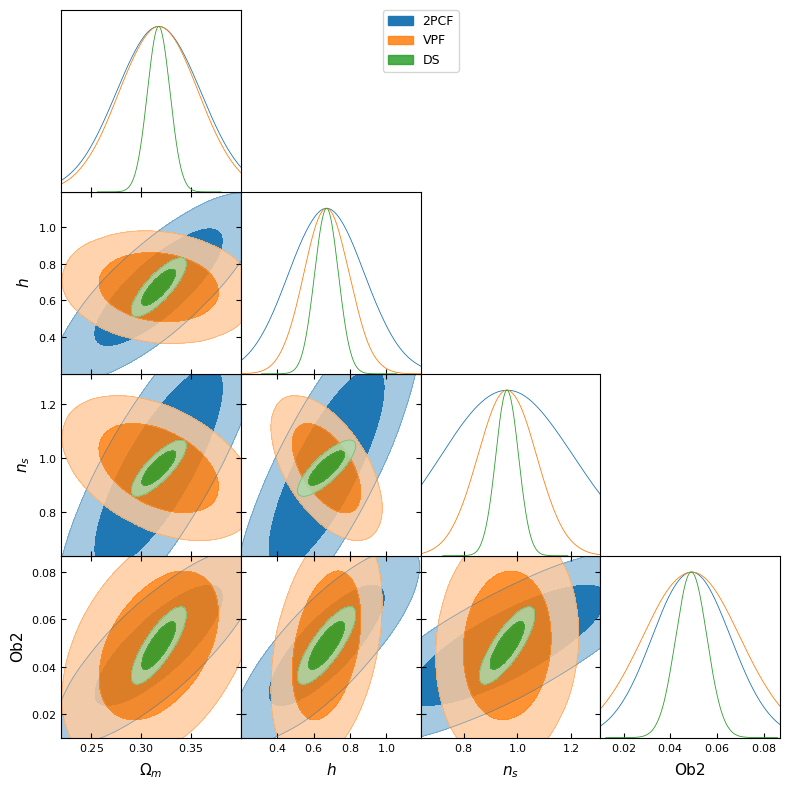

In [17]:
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt


# Computing fisher element Om,h
f_Omh = dChi_dOm @ np.linalg.inv(covfactor*covariance_fid) @ dChi_dh.T
# Computing fisher element Om,ns
f_Omns = dChi_dOm @ np.linalg.inv(covfactor*covariance_fid) @ dChi_dns.T
# Computing fisher element h,ns
f_hns = dChi_dh @ np.linalg.inv(covfactor*covariance_fid) @ dChi_dns.T
# Computing fisher element Om,Ob
f_OmOb = dChi_dOm @ np.linalg.inv(covfactor*covariance_fid) @ dChi_dOb.T
# Computing fisher element h,Ob
f_hOb = dChi_dh @ np.linalg.inv(covfactor*covariance_fid) @ dChi_dOb.T
# Computing fisher element ns,Ob
f_nsOb = dChi_dns @ np.linalg.inv(covfactor*covariance_fid) @ dChi_dOb.T


rho = 0.8 # correlation coefficient
samples = ['Om','h','ns','Ob2']
labels = [r'\Omega_m',r'h',r'n_s']
mean_theta = [mu_Om,h_fid,ns_fid,Ob_fid]
random_state = np.random.default_rng(10)

# add fisher errors as MC samples
#DS
sigma_Om_ds = 0.01128
sigma_h_ds = 0.06560
sigma_ns_ds = 0.04231
sigma_Ob_ds = 0.0067
theta11 = sigma_Om_ds**2
theta12 = rho*sigma_Om_ds*sigma_h_ds
theta13 = rho*sigma_Om_ds*sigma_ns_ds
theta22 = sigma_h_ds**2
theta23 = rho*sigma_h_ds*sigma_ns_ds
theta33 = sigma_ns_ds**2
theta44 = sigma_Ob_ds**2
theta14 = rho*sigma_Om_ds*sigma_Ob_ds
theta24 = rho*sigma_h_ds*sigma_Ob_ds
theta34 = rho*sigma_ns_ds*sigma_Ob_ds
cov_theta = np.array([[theta11, theta12, theta13, theta14],
                      [theta12, theta22, theta23, theta24],
                      [theta13, theta23, theta33, theta34],
                      [theta14, theta24, theta34, theta44]])
samp = random_state.multivariate_normal(mean_theta, cov_theta, size=1000000)
mcs_ds = MCSamples(samples=samp, names=samples, labels=labels)

#VPF
fisher_matrix = np.array([[f_Om, f_Omh, f_Omns, f_OmOb],
                           [f_Omh, f_h, f_hns, f_hOb],
                           [f_Omns, f_hns, f_ns, f_nsOb],
                           [f_OmOb, f_hOb, f_nsOb, f_Ob]])
#fisher_matrix = np.array([[f_Om, f_Omh],
#                          [f_Omh, f_h]])
cov_theta = np.linalg.inv(fisher_matrix) 
#cov_theta = np.array([[sigma_Om**2, 1/f_Omh, 1/f_Omns],
#                      [1/f_Omh, sigma_h**2, 1/f_hns],
#                      [1/f_Omns, 1/f_hns, sigma_ns**2]])
samp = random_state.multivariate_normal(mean_theta, cov_theta, size=1000000)
mcs_vpf = MCSamples(samples=samp, names=samples, labels=labels)


#2PCF
sigma_Om_2pcf = 0.04221
sigma_h_2pcf = 0.20976
sigma_ns_2pcf = 0.24549
sigma_Ob_2pcf = 0.01686
theta11 = sigma_Om_2pcf**2
theta12 = rho*sigma_Om_2pcf*sigma_h_2pcf
theta13 = rho*sigma_Om_2pcf*sigma_ns_2pcf
theta22 = sigma_h_2pcf**2
theta23 = rho*sigma_h_2pcf*sigma_ns_2pcf
theta33 = sigma_ns_2pcf**2
theta44 = sigma_Ob_2pcf**2
theta14 = rho*sigma_Om_2pcf*sigma_Ob_2pcf
theta24 = rho*sigma_h_2pcf*sigma_Ob_2pcf
theta34 = rho*sigma_ns_2pcf*sigma_Ob_2pcf
cov_theta = np.array([[theta11, theta12, theta13, theta14],
                      [theta12, theta22, theta23, theta24],
                      [theta13, theta23, theta33, theta34],
                      [theta14, theta24, theta34, theta44]])
samp = random_state.multivariate_normal(mean_theta, cov_theta, size=1000000)
mcs_2pcf = MCSamples(samples=samp, names=samples, labels=labels)
param_limits = {
    'Om':(0.22, 0.40),
    'Ob2':(0.01, 0.087),
    'h':(0.20, 1.19),
#    's8':(0.65, 1.05),
    'ns':(0.64, 1.31),
#    'Mnu':(-0.65, 0.65)
}

colors =  plt.rcParams['axes.prop_cycle'].by_key()['color']

# Create a GetDist plotter
g = plots.get_subplot_plotter()

method_labels = ['2PCF','VPF','DS']
# Plot the triangle plot
g.triangle_plot([mcs_2pcf,mcs_vpf,mcs_ds], filled=True, legend_labels=method_labels,
                param_limits=param_limits, contour_colors=colors)

# Show the plot
plt.show()  

#### This plot is still not a fair comparison given that the Fisher matrix for the VPF is of smaller dimensions 

In [12]:
# def gaussian(x,mu,sigma,norm=True):
#     g = np.exp(-(x - mu)**2 / (2 * sigma**2))
#     if norm==True:
#         g /= g.max()
#     return g

# import matplotlib.pyplot as plt
# import numpy as np

# fig, ax = plt.subplots(1, 3, figsize=(15, 3)) 

# lw = 2
# mu_Om = 0.3175
# x = np.linspace(mu_Om - 8*sigma_Om, mu_Om + 8*sigma_Om, 100)
# ax[0].plot(x, gaussian(x, mu_Om, 0.04221), label='2PCF', lw=lw)
# ax[0].plot(x, gaussian(x, mu_Om, sigma_Om), label='VPF', lw=lw)
# ax[0].plot(x, gaussian(x, mu_Om, 0.01128), label='DS', lw=lw)
# ax[0].set_xlabel(r'$\Omega_m$')

# x = np.linspace(h_fid - 8*sigma_h, h_fid + 8*sigma_h, 100)
# ax[1].plot(x, gaussian(x, h_fid, 0.20976), label='2PCF', lw=lw)
# ax[1].plot(x, gaussian(x, h_fid, sigma_h), label='VPF', lw=lw)
# ax[1].plot(x, gaussian(x, h_fid, 0.0656), label='DS', lw=lw)
# ax[1].set_xlabel(r'$h$')

# x = np.linspace(ns_fid - 8*sigma_ns, ns_fid + 8*sigma_ns, 100)
# ax[2].plot(x, gaussian(x, ns_fid, 0.24549), label='2PCF', lw=lw)
# ax[2].plot(x, gaussian(x, ns_fid, sigma_ns), label='VPF', lw=lw)
# ax[2].plot(x, gaussian(x, ns_fid, 0.04231), label='DS', lw=lw)
# ax[2].set_xlabel(r'$n_s$')

# ax[0].legend(loc=1)
# plt.show()


### Trying to rewrite this more efficiently

fiducial 2994
Om_m 499
Om_p 499
h_m 499
h_p 499
ns_m 500
ns_p 499
Ob2_m 111
Ob2_p 111
Removed no burn in


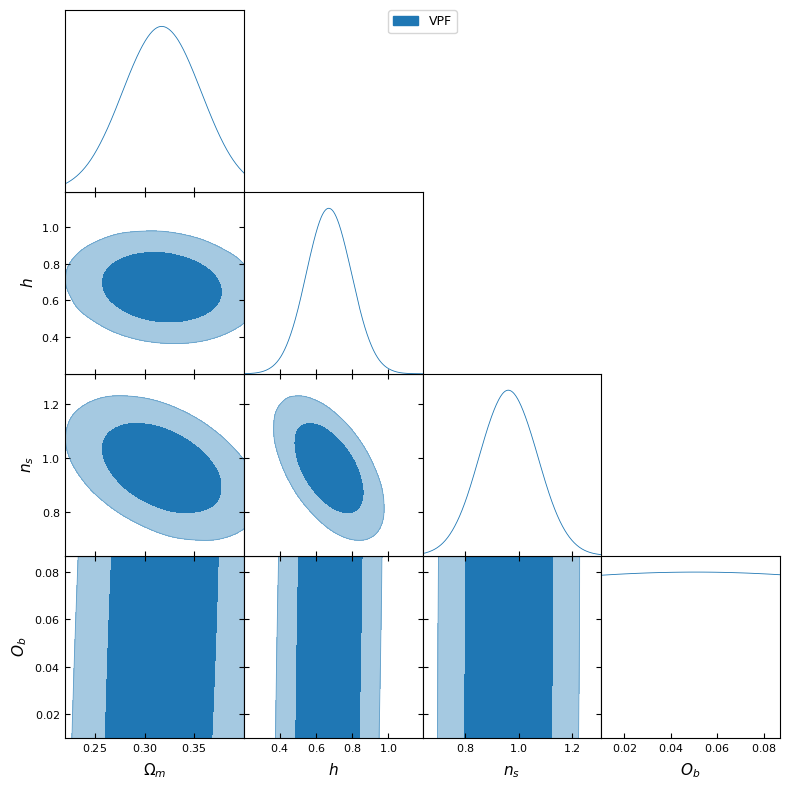

In [1]:
def get_filenames(rmin,rmax,rbin,njk,ns,cosm,space):
    filename = f'vpfdata_{rmin}-{rmax}-{rbin}-{njk}-{ns}-{cosm}-{space}*.dat'
    return filename
def compute_mean_cov(summaries):
    mean = np.mean(summaries, axis=0)
    covariance = np.cov(summaries.T)
    inverse_covariance = np.linalg.solve(
        covariance, np.eye(len(covariance), len(covariance))
    )
    corrm = np.corrcoef(summaries.T)
    return mean, covariance, inverse_covariance, corrm

def get_MeanCovCorrM(cosm):

    import file_parameters as fp

    rmin = fp.file_parameters['rmin']
    rmax = fp.file_parameters['rmax']
    rbin = fp.file_parameters['rbin']
    njk = fp.file_parameters['njk']
    ns = fp.file_parameters['ns']
    space = fp.file_parameters['space']
    filedir = fp.file_parameters['filedir']

    filenames = get_filenames(rmin,rmax,rbin,njk,ns,cosm,space)
    
    path = filedir+filenames

    filelist = glob.glob(path)
    nsim = len(filelist)
    print(cosm, nsim)

    chis = []
    nxis = []
    chi_stds = []

    # Read all files
    for file in filelist:
        #print(file)
        data = ascii.read(file)
        chis.append( data['chi'] )
        nxis.append( data['N_mean']*data['xi'] )
        chi_stds.append( data['chi_std'] )

    chi_array = np.array(chis)
    mean = np.mean(chi_array, axis=0)
    covariance = np.cov(chi_array.T)
    corrm = np.corrcoef(chi_array.T)

    return mean, covariance, corrm
    
def get_derivatives(cosm_param):
    
    import cosm_parameters as cp

    step = cp.cosm_param[cosm_param]['step']

    mean_m = get_MeanCovCorrM(cosm_param+'_m')[0]
    mean_p = get_MeanCovCorrM(cosm_param+'_p')[0]

    dChi_dtheta = (mean_p-mean_m)/(2*step)
    
    return dChi_dtheta

def get_covmatrix(summaries):
    covariance = np.cov(summaries.T)
    inverse_covariance = np.linalg.solve(
        covariance, np.eye(len(covariance), len(covariance))
    )
    corrm = np.corrcoef(summaries.T)
    return covariance, inverse_covariance, corrm

def get_covfactor():

    import file_parameters as fp
    import cosm_parameters as cp

    rmin = fp.file_parameters['rmin']
    rmax = fp.file_parameters['rmax']
    nbin = fp.file_parameters['rbin']
    njk = fp.file_parameters['njk']
    ns = fp.file_parameters['ns']
    space = fp.file_parameters['space']
    filedir = fp.file_parameters['filedir']
    filenames = get_filenames(rmin,rmax,nbin,njk,ns,'fiducial',space)
    path = filedir+filenames
    filelist = glob.glob(path)
    nsim = len(filelist)

    nparam = len(cp.cosm_param)

    covfactor = (nsim-1)/(nsim-nbin+nparam-1)

    return covfactor

def fisher_elementOld(cosm_param1, cosm_param2, covariance_fid):

    dChi_dtheta1 = get_derivatives(cosm_param1)

    if cosm_param1==cosm_param2:
        dChi_dtheta2 = dChi_dtheta1
    else:
        dChi_dtheta2 = get_derivatives(cosm_param2)     

    # mean_fid, covariance_fid, corrm_fid = \
    #     get_MeanCovCorrM('fiducial')

    covfactor = get_covfactor()

    f = dChi_dtheta1 \
        @ np.linalg.inv(covfactor*covariance_fid) \
            @ dChi_dtheta2.T
    
    return f

def fisher_element(dChi_dtheta1, dChi_dtheta2, covfactor, covariance_fid):

    f = dChi_dtheta1 \
        @ np.linalg.inv(covfactor*covariance_fid) \
            @ dChi_dtheta2.T
    
    return f

#f_Om = fisher_element('Om','Om')
#print(f_Om)

from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import glob
import numpy as np
from astropy.io import ascii
import cosm_parameters as cp

mean_fid, covariance_fid, corrm_fid = \
    get_MeanCovCorrM('fiducial')

covfactor = get_covfactor()

#Computing derivatives
dOm = get_derivatives('Om')
dh = get_derivatives('h')
dns = get_derivatives('ns')
dOb = get_derivatives('Ob2')

# Computing diagonal fisher elements
f_Om = fisher_element(dOm,dOm,covfactor,covariance_fid)
f_h = fisher_element(dh,dh,covfactor,covariance_fid)
f_ns = fisher_element(dns,dns,covfactor,covariance_fid)
f_Ob = fisher_element(dOb,dOb,covfactor,covariance_fid)
# Computing fisher element Om,h
f_Omh = fisher_element(dOm,dh,covfactor,covariance_fid)
# Computing fisher element Om,ns
f_Omns = fisher_element(dOm,dns,covfactor,covariance_fid)
# Computing fisher element h,ns
f_hns = fisher_element(dh,dns,covfactor,covariance_fid)
# Computing fisher element Om,Ob
f_OmOb = fisher_element(dOm,dOb,covfactor,covariance_fid)
# Computing fisher element h,Ob
f_hOb = fisher_element(dh,dOb,covfactor,covariance_fid)
# Computing fisher element ns,Ob
f_nsOb = fisher_element(dns,dOb,covfactor,covariance_fid)

samples = ['Om','h','ns','Ob2']


labels = [r'\Omega_m',r'h',r'n_s',r'O_b']
mean_theta = [cp.cosm_param['Om']['fid'],cp.cosm_param['h']['fid'],\
              cp.cosm_param['ns']['fid'],cp.cosm_param['Ob2']['fid']]
random_state = np.random.default_rng(10)

#VPF
fisher_matrix = np.array([[f_Om, f_Omh, f_Omns, f_OmOb],
                           [f_Omh, f_h, f_hns, f_hOb],
                           [f_Omns, f_hns, f_ns, f_nsOb],
                           [f_OmOb, f_hOb, f_nsOb, f_Ob]])
cov_theta = np.linalg.inv(fisher_matrix) 
samp = random_state.multivariate_normal(mean_theta, cov_theta, size=1000000)
mcs_vpf = MCSamples(samples=samp, names=samples, labels=labels)

param_limits = {
    'Om':(0.22, 0.40),
    'Ob2':(0.01, 0.087),
    'h':(0.20, 1.19),
#    's8':(0.65, 1.05),
    'ns':(0.64, 1.31),
#    'Mnu':(-0.65, 0.65)
}
colors =  plt.rcParams['axes.prop_cycle'].by_key()['color']
# Create a GetDist plotter
g = plots.get_subplot_plotter()

method_labels = ['VPF']
# Plot the triangle plot
g.triangle_plot([mcs_vpf], filled=True, legend_labels=method_labels,
                param_limits=param_limits, contour_colors=colors)

# Show the plot
plt.show()  


## Same for 2pcf

fiducial 2214
h_m 501
h_p 500
[-0.33914677 -0.13215178 -0.06008678 -0.03001912 -0.02084405 -0.01625547
 -0.00453537 -0.00037574  0.00040142 -0.04432765 -0.01751419 -0.01163763
 -0.00814417 -0.00604664 -0.00534851 -0.00497962 -0.0039009  -0.00278331]
[[0.00012492]] 0.00012491689198552576
Removed no burn in


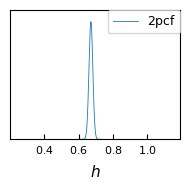

In [16]:
def get_filename_2pcf(rmin,rmax,nbins_m,nbins_s,cosm,space,axis):
    filename = f'2pcfdata_{rmin}-{rmax}-{nbins_m}-{nbins_s}-{cosm}-{space}{axis}-*.dat'
    return filename

def get_filenames_vpf(rmin,rmax,rbin,njk,ns,cosm,space):
    filename = f'vpfdata_{rmin}-{rmax}-{rbin}-{njk}-{ns}-{cosm}-{space}*.dat'
    return filename

def compute_mean_cov(summaries):
    mean = np.mean(summaries, axis=0)
    covariance = np.cov(summaries.T)
    inverse_covariance = np.linalg.solve(
        covariance, np.eye(len(covariance), len(covariance))
    )
    corrm = np.corrcoef(summaries.T)
    return mean, covariance, inverse_covariance, corrm

def get_MeanCovCorrM(cosm):

    import file_parameters as fp

    rmin = fp.file_parameters_2pcf['rmin']
    rmax = fp.file_parameters_2pcf['rmax']
    nbins_s = fp.file_parameters_2pcf['nbins_s']
    nbins_m = fp.file_parameters_2pcf['nbins_m']
    space = fp.file_parameters_2pcf['space']
    filedir = fp.file_parameters_2pcf['filedir']
    axis = fp.file_parameters_2pcf['axis']

    filenames = get_filename_2pcf(rmin,rmax,nbins_m,nbins_s,cosm,space,axis)
    
    path = filedir+f'{cosm}/'+filenames

    filelist = glob.glob(path)
    nsim = len(filelist)
    print(cosm, nsim)

    xi_ls = []

    # Read all files
    for file in filelist:

        data = ascii.read(file)
        xi_ls.append( np.concatenate((data['xi0'],data['xi2']),axis=None) )

    xi_ls_array = np.array(xi_ls)
    #print(xi_ls)
    mean = np.mean(xi_ls_array, axis=0)
    covariance = np.cov(xi_ls_array.T)
    corrm = np.corrcoef(xi_ls_array.T)

    return mean, covariance, corrm
    
def get_derivatives(cosm_param):
    
    import cosm_parameters as cp

    step = cp.cosm_param[cosm_param]['step']

    mean_m = get_MeanCovCorrM(cosm_param+'_m')[0]
    mean_p = get_MeanCovCorrM(cosm_param+'_p')[0]

    dChi_dtheta = (mean_p-mean_m)/(2*step)
    
    return dChi_dtheta

def get_covmatrix(summaries):
    covariance = np.cov(summaries.T)
    inverse_covariance = np.linalg.solve(
        covariance, np.eye(len(covariance), len(covariance))
    )
    corrm = np.corrcoef(summaries.T)
    return covariance, inverse_covariance, corrm

def get_covfactor():

    import file_parameters as fp
    import cosm_parameters as cp

    cosm = 'fiducial'

    rmin = fp.file_parameters_2pcf['rmin']
    rmax = fp.file_parameters_2pcf['rmax']
    nbins_s = fp.file_parameters_2pcf['nbins_s']
    nbins_m = fp.file_parameters_2pcf['nbins_m']
    space = fp.file_parameters_2pcf['space']
    filedir = fp.file_parameters_2pcf['filedir']
    axis = fp.file_parameters_2pcf['axis']
    filenames = get_filename_2pcf(rmin,rmax,nbins_m,nbins_s,cosm,space,axis)
    path = filedir+f'{cosm}/'+filenames
    filelist = glob.glob(path)
    nsim = len(filelist)

    nparam = len(cp.cosm_param)

    covfactor = (nsim-1)/(nsim-nbins_s+nparam-1)

    return covfactor


def fisher_element(dChi_dtheta1, dChi_dtheta2, covfactor, covariance_fid):

    f = dChi_dtheta1 \
        @ np.linalg.inv(covfactor*covariance_fid) \
            @ dChi_dtheta2.T
    
    return f


from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import glob
import numpy as np
from astropy.io import ascii
import cosm_parameters as cp

mean_fid, covariance_fid, corrm_fid = \
    get_MeanCovCorrM('fiducial')


covfactor = get_covfactor()


#Computing derivatives
#dOm = get_derivatives('Om')
dh = get_derivatives('h')
print(dh)
#dns = get_derivatives('ns')
#dOb = get_derivatives('Ob2')

# Computing diagonal fisher elements
# f_Om = fisher_element(dOm,dOm,covfactor,covariance_fid)
f_h = fisher_element(dh,dh,covfactor,covariance_fid)
# f_ns = fisher_element(dns,dns,covfactor,covariance_fid)
# f_Ob = fisher_element(dOb,dOb,covfactor,covariance_fid)
# # Computing fisher element Om,h
# f_Omh = fisher_element(dOm,dh,covfactor,covariance_fid)
# # Computing fisher element Om,ns
# f_Omns = fisher_element(dOm,dns,covfactor,covariance_fid)
# # Computing fisher element h,ns
# f_hns = fisher_element(dh,dns,covfactor,covariance_fid)
# # Computing fisher element Om,Ob
# f_OmOb = fisher_element(dOm,dOb,covfactor,covariance_fid)
# # Computing fisher element h,Ob
# f_hOb = fisher_element(dh,dOb,covfactor,covariance_fid)
# # Computing fisher element ns,Ob
# f_nsOb = fisher_element(dns,dOb,covfactor,covariance_fid)

samples = ['h']


labels = [r'h']
mean_theta = [cp.cosm_param['h']['fid']]
random_state = np.random.default_rng(10)

#2pcf
fisher_matrix = np.array([[f_h]])
cov_theta = np.linalg.inv(fisher_matrix) 
print(cov_theta,1/f_h)
samp = random_state.multivariate_normal(mean_theta, cov_theta, size=1000000)
mcs_2pcf = MCSamples(samples=samp, names=samples, labels=labels)

param_limits = {
    'Om':(0.22, 0.40),
    'Ob2':(0.01, 0.087),
    'h':(0.20, 1.19),
#    's8':(0.65, 1.05),
    'ns':(0.64, 1.31),
#    'Mnu':(-0.65, 0.65)
}
colors =  plt.rcParams['axes.prop_cycle'].by_key()['color']
# Create a GetDist plotter
g = plots.get_subplot_plotter()

method_labels = ['2pcf']
# Plot the triangle plot
g.triangle_plot([mcs_2pcf], filled=True, legend_labels=method_labels,
                param_limits=param_limits, contour_colors=colors)

# Show the plot
plt.show()  


## Both at the same time

fiducial 2214
Om_m 499
Om_p 499
h_m 501
h_p 500
ns_m 499
ns_p 499
Removed no burn in
fiducial 2994
h_m 499
h_p 499
Om_m 499
Om_p 499
ns_m 500
ns_p 499
Removed no burn in


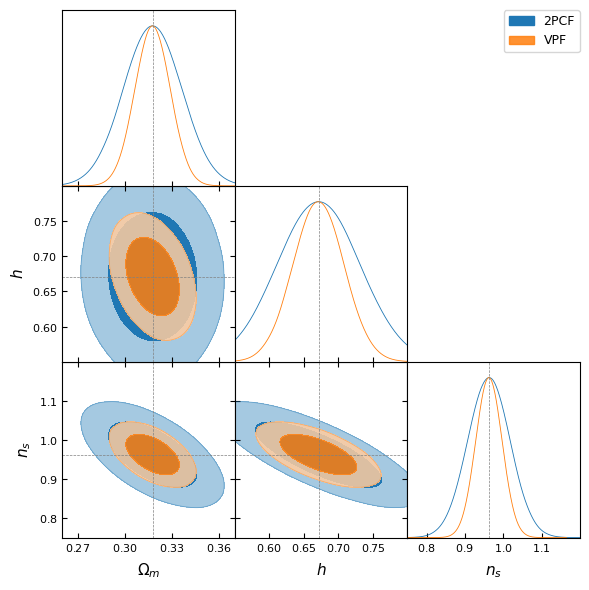

In [1]:
def get_filename_2pcf(rmin,rmax,nbins_m,nbins_s,cosm,space,axis):
    filename = f'2pcfdata_{rmin}-{rmax}-{nbins_m}-{nbins_s}-{cosm}-{space}{axis}-*.dat'
    return filename

def get_filenames_vpf(rmin,rmax,rbin,njk,ns,cosm,space):
    filename = f'vpfdata_{rmin}-{rmax}-{rbin}-{njk}-{ns}-{cosm}-{space}*.dat'
    return filename

def compute_mean_cov(summaries):
    mean = np.mean(summaries, axis=0)
    covariance = np.cov(summaries.T)
    inverse_covariance = np.linalg.solve(
        covariance, np.eye(len(covariance), len(covariance))
    )
    corrm = np.corrcoef(summaries.T)
    return mean, covariance, inverse_covariance, corrm

def get_MeanCovCorrM_2pcf(cosm):

    import file_parameters as fp

    rmin = fp.file_parameters_2pcf['rmin']
    rmax = fp.file_parameters_2pcf['rmax']
    nbins_s = fp.file_parameters_2pcf['nbins_s']
    nbins_m = fp.file_parameters_2pcf['nbins_m']
    space = fp.file_parameters_2pcf['space']
    filedir = fp.file_parameters_2pcf['filedir']
    axis = fp.file_parameters_2pcf['axis']

    filenames = get_filename_2pcf(rmin,rmax,nbins_m,nbins_s,cosm,space,axis)
    
    path = filedir+f'{cosm}/'+filenames

    filelist = glob.glob(path)
    nsim = len(filelist)
    print(cosm, nsim)

    xi_ls = []

    # Read all files
    for file in filelist:

        data = ascii.read(file)
        xi_ls.append( np.concatenate((data['xi0'],data['xi2']),axis=None) )

    xi_ls_array = np.array(xi_ls)
    #print(xi_ls)
    mean = np.mean(xi_ls_array, axis=0)
    covariance = np.cov(xi_ls_array.T)
    corrm = np.corrcoef(xi_ls_array.T)

    return mean, covariance, corrm

def get_MeanCovCorrM_vpf(cosm):

    import file_parameters as fp

    rmin = fp.file_parameters_vpf['rmin']
    rmax = fp.file_parameters_vpf['rmax']
    rbin = fp.file_parameters_vpf['rbin']
    njk = fp.file_parameters_vpf['njk']
    ns = fp.file_parameters_vpf['ns']
    space = fp.file_parameters_vpf['space']
    filedir = fp.file_parameters_vpf['filedir']

    filenames = get_filenames_vpf(rmin,rmax,rbin,njk,ns,cosm,space)
    
    path = filedir+filenames
    filelist = glob.glob(path)
    nsim = len(filelist)
    print(cosm, nsim)

    chis = []
    nxis = []
    chi_stds = []

    # Read all files
    for file in filelist:
        #print(file)
        data = ascii.read(file)
        chis.append( data['chi'] )
        nxis.append( data['N_mean']*data['xi'] )
        chi_stds.append( data['chi_std'] )

    chi_array = np.array(chis)
    mean = np.mean(chi_array, axis=0)
    covariance = np.cov(chi_array.T)
    corrm = np.corrcoef(chi_array.T)

    return mean, covariance, corrm

def get_derivatives(cosm_param,stat):
    
    import cosm_parameters as cp

    step = cp.cosm_param[cosm_param]['step']

    if stat=='vpf':
        mean_m = get_MeanCovCorrM_vpf(cosm_param+'_m')[0]
        mean_p = get_MeanCovCorrM_vpf(cosm_param+'_p')[0]
    if stat=='2pcf':
        mean_m = get_MeanCovCorrM_2pcf(cosm_param+'_m')[0]
        mean_p = get_MeanCovCorrM_2pcf(cosm_param+'_p')[0]

    dChi_dtheta = (mean_p-mean_m)/(2*step)
    
    return dChi_dtheta

def get_covmatrix(summaries):
    covariance = np.cov(summaries.T)
    inverse_covariance = np.linalg.solve(
        covariance, np.eye(len(covariance), len(covariance))
    )
    corrm = np.corrcoef(summaries.T)
    return covariance, inverse_covariance, corrm

def get_covfactor(stat):

    import file_parameters as fp
    import cosm_parameters as cp

    cosm = 'fiducial'

    if stat=='2pcf':
        rmin = fp.file_parameters_2pcf['rmin']
        rmax = fp.file_parameters_2pcf['rmax']
        nbins_s = fp.file_parameters_2pcf['nbins_s']
        nbins_m = fp.file_parameters_2pcf['nbins_m']
        space = fp.file_parameters_2pcf['space']
        filedir = fp.file_parameters_2pcf['filedir']
        axis = fp.file_parameters_2pcf['axis']
        filenames = get_filename_2pcf(rmin,rmax,nbins_m,nbins_s,cosm,space,axis)
        bins = nbins_s

    if stat=='vpf':
        rmin = fp.file_parameters_vpf['rmin']
        rmax = fp.file_parameters_vpf['rmax']
        nbin = fp.file_parameters_vpf['rbin']
        njk = fp.file_parameters_vpf['njk']
        ns = fp.file_parameters_vpf['ns']
        space = fp.file_parameters_vpf['space']
        filedir = fp.file_parameters_vpf['filedir']
        filenames = get_filenames_vpf(rmin,rmax,nbin,njk,ns,'fiducial',space)
        bins = nbin

    path = filedir+f'{cosm}/'+filenames
    filelist = glob.glob(path)
    nsim = len(filelist)

    nparam = len(cp.cosm_param)


    covfactor = (nsim-1)/(nsim-bins+nparam-1)

    return covfactor


def fisher_element(dChi_dtheta1, dChi_dtheta2, covfactor, covariance_fid):

    f = dChi_dtheta1 \
        @ np.linalg.inv(covfactor*covariance_fid) \
            @ dChi_dtheta2.T
    
    return f


from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import glob
import numpy as np
from astropy.io import ascii
import cosm_parameters as cp

samples = ['Om','h','ns']
labels = [r'\Omega_m',r'h',r'n_s']
mean_theta = [cp.cosm_param['Om']['fid'],cp.cosm_param['h']['fid'],cp.cosm_param['ns']['fid']]
random_state = np.random.default_rng(10)


############################################################
#2pcf
############################################################

# From fiducial cosm. get mean, covariance, correlation matrix
# and covariance correction factor
mean_fid, covariance_fid, corrm_fid = \
    get_MeanCovCorrM_2pcf('fiducial')

covfactor = get_covfactor('2pcf')

#Computing derivatives
dOm = get_derivatives('Om', '2pcf')
dh = get_derivatives('h','2pcf')
dns = get_derivatives('ns','2pcf')

# Computing diagonal fisher elements
f_Om = fisher_element(dOm,dOm,covfactor,covariance_fid)
f_h = fisher_element(dh,dh,covfactor,covariance_fid)
f_ns = fisher_element(dns,dns,covfactor,covariance_fid)
# Computing off-diagonal fisher elements
f_Omh = fisher_element(dOm,dh,covfactor,covariance_fid)
f_Omns = fisher_element(dOm,dns,covfactor,covariance_fid)
f_hns = fisher_element(dh,dns,covfactor,covariance_fid)

fisher_matrix = np.array([[f_Om, f_Omh, f_Omns],
                          [f_Omh, f_h, f_hns],
                          [f_Omns, f_hns, f_ns]])
cov_theta = np.linalg.inv(fisher_matrix) 
#print(cov_theta,1/f_h)
samp = random_state.multivariate_normal(mean_theta, cov_theta, size=1000000)
mcs_2pcf = MCSamples(samples=samp, names=samples, labels=labels)


############################################################
#vpf
############################################################

# From fiducial cosm. get mean, covariance, correlation matrix
# and covariance correction factor
mean_fid, covariance_fid, corrm_fid = \
    get_MeanCovCorrM_vpf('fiducial')

covfactor = get_covfactor('vpf')

#Computing derivatives
dh = get_derivatives('h','vpf')
dOm = get_derivatives('Om', 'vpf')
dns = get_derivatives('ns','vpf')

# Computing diagonal fisher elements
f_Om = fisher_element(dOm,dOm,covfactor,covariance_fid)
f_h = fisher_element(dh,dh,covfactor,covariance_fid)
f_ns = fisher_element(dns,dns,covfactor,covariance_fid)
# Computing off-diagonal fisher elements
f_Omh = fisher_element(dOm,dh,covfactor,covariance_fid)
f_Omns = fisher_element(dOm,dns,covfactor,covariance_fid)
f_hns = fisher_element(dh,dns,covfactor,covariance_fid)

fisher_matrix = np.array([[f_Om, f_Omh, f_Omns],
                          [f_Omh, f_h, f_hns],
                          [f_Omns, f_hns, f_ns]])
cov_theta = np.linalg.inv(fisher_matrix) 
#print(cov_theta,1/f_h)
samp = random_state.multivariate_normal(mean_theta, cov_theta, size=1000000)
mcs_vpf = MCSamples(samples=samp, names=samples, labels=labels)




colors =  plt.rcParams['axes.prop_cycle'].by_key()['color']
# Create a GetDist plotter
g = plots.get_subplot_plotter()


param_limits = {
    'Om':(0.26, 0.37),
    'Ob2':(0.01, 0.087),
    'h':(0.55, .8),
#    's8':(0.65, 1.05),
    'ns':(0.75, 1.2),
#    'Mnu':(-0.65, 0.65)
}
method_labels = ['2PCF','VPF']
# Plot the triangle plot
g.triangle_plot([mcs_2pcf,mcs_vpf], filled=True, legend_labels=method_labels,
                param_limits=param_limits, contour_colors=colors)
g.add_param_markers({'Om':cp.cosm_param['Om']['fid'],'h':cp.cosm_param['h']['fid'],\
                     'ns':cp.cosm_param['ns']['fid']})

# Show the plot
plt.show()  


### I want to generalize the code for arbitrary number of parameters

fiducial 2214
Om_m 499
Om_p 499
h_m 501
h_p 500
ns_m 499
ns_p 499
Removed no burn in
fiducial 2994
Om_m 499
Om_p 499
h_m 499
h_p 499
ns_m 500
ns_p 499
Removed no burn in


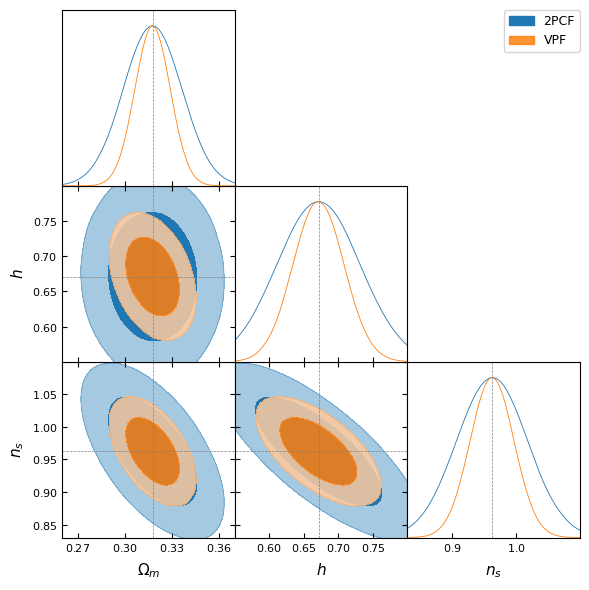

In [3]:
def get_filename_2pcf(rmin,rmax,nbins_m,nbins_s,cosm,space,axis):
    filename = f'2pcfdata_{rmin}-{rmax}-{nbins_m}-{nbins_s}-{cosm}-{space}{axis}-*.dat'
    return filename

def get_filenames_vpf(rmin,rmax,rbin,njk,ns,cosm,space):
    filename = f'vpfdata_{rmin}-{rmax}-{rbin}-{njk}-{ns}-{cosm}-{space}*.dat'
    return filename

def compute_mean_cov(summaries):
    mean = np.mean(summaries, axis=0)
    covariance = np.cov(summaries.T)
    inverse_covariance = np.linalg.solve(
        covariance, np.eye(len(covariance), len(covariance))
    )
    corrm = np.corrcoef(summaries.T)
    return mean, covariance, inverse_covariance, corrm

def get_MeanCovCorrM_2pcf(cosm):

    #import file_parameters as fp

    rmin = file_parameters_2pcf['rmin']
    rmax = file_parameters_2pcf['rmax']
    nbins_s = file_parameters_2pcf['nbins_s']
    nbins_m = file_parameters_2pcf['nbins_m']
    space = file_parameters_2pcf['space']
    filedir = file_parameters_2pcf['filedir']
    axis = file_parameters_2pcf['axis']

    filenames = get_filename_2pcf(rmin,rmax,nbins_m,nbins_s,cosm,space,axis)
    
    path = filedir+f'{cosm}/'+filenames

    filelist = glob.glob(path)
    nsim = len(filelist)
    print(cosm, nsim)

    xi_ls = []

    # Read all files
    for file in filelist:

        data = ascii.read(file)
        xi_ls.append( np.concatenate((data['xi0'],data['xi2']),axis=None) )

    xi_ls_array = np.array(xi_ls)
    #print(xi_ls)
    mean = np.mean(xi_ls_array, axis=0)
    covariance = np.cov(xi_ls_array.T)
    corrm = np.corrcoef(xi_ls_array.T)

    return mean, covariance, corrm

def get_MeanCovCorrM_vpf(cosm):

    #import file_parameters as fp

    rmin = file_parameters_vpf['rmin']
    rmax = file_parameters_vpf['rmax']
    rbin = file_parameters_vpf['rbin']
    njk = file_parameters_vpf['njk']
    ns = file_parameters_vpf['ns']
    space = file_parameters_vpf['space']
    filedir = file_parameters_vpf['filedir']

    filenames = get_filenames_vpf(rmin,rmax,rbin,njk,ns,cosm,space)
    
    path = filedir+filenames
    filelist = glob.glob(path)
    nsim = len(filelist)
    print(cosm, nsim)

    chis = []
    nxis = []
    chi_stds = []

    # Read all files
    for file in filelist:
        data = ascii.read(file)
        chis.append( data['chi'] )
        nxis.append( data['N_mean']*data['xi'] )
        chi_stds.append( data['chi_std'] )

    chi_array = np.array(chis)
    mean = np.mean(chi_array, axis=0)
    covariance = np.cov(chi_array.T)
    corrm = np.corrcoef(chi_array.T)

    return mean, covariance, corrm

def get_derivatives(cosm_param,stat):
    
    import cosm_parameters as cp

    step = cp.cosm_param[cosm_param]['step']

    if stat=='vpf':
        mean_m = get_MeanCovCorrM_vpf(cosm_param+'_m')[0]
        mean_p = get_MeanCovCorrM_vpf(cosm_param+'_p')[0]
    if stat=='2pcf':
        mean_m = get_MeanCovCorrM_2pcf(cosm_param+'_m')[0]
        mean_p = get_MeanCovCorrM_2pcf(cosm_param+'_p')[0]

    dChi_dtheta = (mean_p-mean_m)/(2*step)
    
    return dChi_dtheta

def get_covmatrix(summaries):
    covariance = np.cov(summaries.T)
    inverse_covariance = np.linalg.solve(
        covariance, np.eye(len(covariance), len(covariance))
    )
    corrm = np.corrcoef(summaries.T)
    return covariance, inverse_covariance, corrm

def get_covfactor(stat):

    #import file_parameters as fp
    import cosm_parameters as cp

    cosm = 'fiducial'

    if stat=='2pcf':
        rmin = file_parameters_2pcf['rmin']
        rmax = file_parameters_2pcf['rmax']
        nbins_s = file_parameters_2pcf['nbins_s']
        nbins_m = file_parameters_2pcf['nbins_m']
        space = file_parameters_2pcf['space']
        filedir = file_parameters_2pcf['filedir']
        axis = file_parameters_2pcf['axis']
        filenames = get_filename_2pcf(rmin,rmax,nbins_m,nbins_s,cosm,space,axis)
        bins = nbins_s

    if stat=='vpf':
        rmin = file_parameters_vpf['rmin']
        rmax = file_parameters_vpf['rmax']
        nbin = file_parameters_vpf['rbin']
        njk = file_parameters_vpf['njk']
        ns = file_parameters_vpf['ns']
        space = file_parameters_vpf['space']
        filedir = file_parameters_vpf['filedir']
        filenames = get_filenames_vpf(rmin,rmax,nbin,njk,ns,'fiducial',space)
        bins = nbin

    path = filedir+f'{cosm}/'+filenames
    filelist = glob.glob(path)
    nsim = len(filelist)

    nparam = len(cp.cosm_param)


    covfactor = (nsim-1)/(nsim-bins+nparam-1)

    return covfactor


def fisher_element(dChi_dtheta1, dChi_dtheta2, covfactor, covariance_fid):

    f = dChi_dtheta1 \
        @ np.linalg.inv(covfactor*covariance_fid) \
            @ dChi_dtheta2.T
    
    return f


from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import glob
import numpy as np
from astropy.io import ascii
import cosm_parameters as cp
#import file_parameters as fp

param_limits = {
    'Om':(0.26, 0.37),
    'Ob2':(0.01, 0.087),
    'h':(0.55, .8),
    's8':(0.65, 1.05),
    'ns':(0.83, 1.1),
    'Mnu':(-0.65, 0.65)
}

file_parameters_vpf = dict(
    {   
        "ns":int(10000),
        "rbin":int(13),
        "rmin":3.,
        "rmax":int(25),
        "njk":int(10),
        "space":'zspace',
        "filedir":'../data/output/'
    })

file_parameters_2pcf = dict(
    {   
        "nbins_s":9,  #9, 12, 29
        "nbins_m":10,  #10, 30
        "rmin":10,     #3, 10
        "rmax":150,    #25, 150
        "space":'zspace',
        "filedir":'../data/output/2pcf/',
        "axis":0
    })

samples = ['Om','h','ns']
labels = [r'\Omega_m',r'h',r'n_s']
mean_theta = [cp.cosm_param[sample]['fid'] for sample in samples]
random_state = np.random.default_rng(10)


############################################################
#2pcf
############################################################

# From fiducial cosm. get mean, covariance, correlation matrix
# and covariance correction factor
mean_fid, covariance_fid, corrm_fid = \
    get_MeanCovCorrM_2pcf('fiducial')

covfactor = get_covfactor('2pcf')

#Computing derivatives and Fisher matrix
derivatives = [get_derivatives(sample,'2pcf') for sample in samples]

fisher_matrix = np.array([fisher_element(derivatives[i],derivatives[j],covfactor,covariance_fid) \
                          for i in range(len(samples)) for j in range(len(samples))]).\
                            reshape(len(samples),len(samples))

cov_theta = np.linalg.inv(fisher_matrix) 
samp = random_state.multivariate_normal(mean_theta, cov_theta, size=1000000)
mcs_2pcf = MCSamples(samples=samp, names=samples, labels=labels)


############################################################
#vpf
############################################################

# From fiducial cosm. get mean, covariance, correlation matrix
# and covariance correction factor
mean_fid, covariance_fid, corrm_fid = \
    get_MeanCovCorrM_vpf('fiducial')

covfactor = get_covfactor('vpf')

#Computing derivatives and Fisher matrix
derivatives = [get_derivatives(sample,'vpf') for sample in samples]

fisher_matrix = np.array([fisher_element(derivatives[i],derivatives[j],covfactor,covariance_fid) \
                          for i in range(len(samples)) for j in range(len(samples))]).\
                            reshape(len(samples),len(samples))

cov_theta = np.linalg.inv(fisher_matrix) 
samp = random_state.multivariate_normal(mean_theta, cov_theta, size=1000000)
mcs_vpf = MCSamples(samples=samp, names=samples, labels=labels)


############################################################
# plot
############################################################

colors =  plt.rcParams['axes.prop_cycle'].by_key()['color']
# Create a GetDist plotter
g = plots.get_subplot_plotter()



method_labels = ['2PCF','VPF']
# Plot the triangle plot
g.triangle_plot([mcs_2pcf,mcs_vpf], filled=True, legend_labels=method_labels,
                param_limits=param_limits, contour_colors=colors)
g.add_param_markers({'Om':cp.cosm_param['Om']['fid'],'h':cp.cosm_param['h']['fid'],\
                     'ns':cp.cosm_param['ns']['fid']})

# Show the plot
plt.show()  
